In [44]:
import librosa
import pandas as pd
import matplotlib.pyplot as plt

### Add Modular Augmentation in the Raw Waveform
- TimeShift, FreqShift
### Add Modular Augmentation in the log of melSpectrogram
- TimeMask , FreqMask

In [45]:
from src.settings import DATA_DIR, PROCESSED_DIR
meta_data = pd.read_csv(os.path.join(DATA_DIR, "meta_data.csv"))

In [48]:
## load the audio data
sr = 44100
rand_sound = meta_data.sample()
rand_sound_path = os.path.join( PROCESSED_DIR , 'train' , rand_sound.filename.item())
wav, sr = librosa.load( rand_sound_path   , sr=sr)

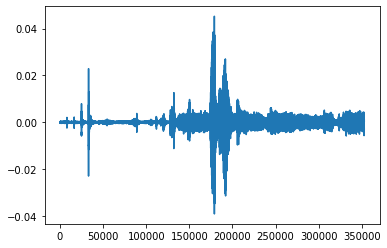

In [49]:
len(wav) == 44100 * 8 , wav.min() , wav.max() , wav.min()
plt.plot(wav)

In [50]:
from pydub.playback import play
from pydub import AudioSegment

C:\Users\Robin\AppData\Local\Continuum\anaconda3\envs\audio\lib\site-packages\pydub\utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
C:\Users\Robin\AppData\Local\Continuum\anaconda3\envs\audio\lib\site-packages\pydub\utils.py:179: RuntimeWarning: Couldn't find ffplay or avplay - defaulting to ffplay, but may not work
  warn("Couldn't find ffplay or avplay - defaulting to ffplay, but may not work", RuntimeWarning)


In [51]:
def play_sound(sound_file_path):
    ## Check one such example for Verification
    pos_sound = AudioSegment.from_wav(sound_file_path)
    print(pos_sound)
    play( pos_sound )
    print('playing stopped')

In [52]:
play_sound( rand_sound_path ) 

playing stopped


In [53]:
wav, sr = librosa.load( rand_sound_path , sr=sr)

In [54]:
wav

array([-6.1035156e-05, -1.9836426e-04, -1.0681152e-04, ...,
        8.8500977e-04,  9.6130371e-04,  1.0528564e-03], dtype=float32)

In [55]:
import scipy.io.wavfile

In [56]:
import audiomentations
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import numpy as np

SAMPLE_RATE = 44100

##Each of these possible Transformation has probability of 50 percent

## WaveForm Transform ##

augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
])

In [57]:
augment( wav , sr )

array([0.00169669, 0.00180849, 0.00186216, ..., 0.00124438, 0.00139965,
       0.00157088], dtype=float32)

In [58]:
g_noise = AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=1)
t_stretch = TimeStretch(min_rate=0.8, max_rate=1.25, p=1)
pitch_shift = PitchShift(min_semitones=-4, max_semitones=4, p=1) ## A Good TRANSFORM
simp_shift = Shift(min_fraction=-0.5, max_fraction=0.5, p=1)
# time_mask = audiomentations.TimeMask(p = 1) ## not a good idea .. Frequency Mask seems more okayish

freq_mask = audiomentations.FrequencyMask(p=1)

In [65]:
all_transforms = [wav]
for t in [g_noise, t_stretch, pitch_shift, simp_shift, freq_mask]:
    all_transforms.append( t( wav , sr ) )

In [66]:
def plot_waveform_transform(all_transforms):
    
    fig, axes = plt.subplots(3,2, figsize=(20,8))
    # plt.figure( figsize=( 20,8 ) )
    for i, ax in enumerate(axes.flatten()):
        try:
            ax.plot( all_transforms[i] )
        except:
            continue

    plt.show()

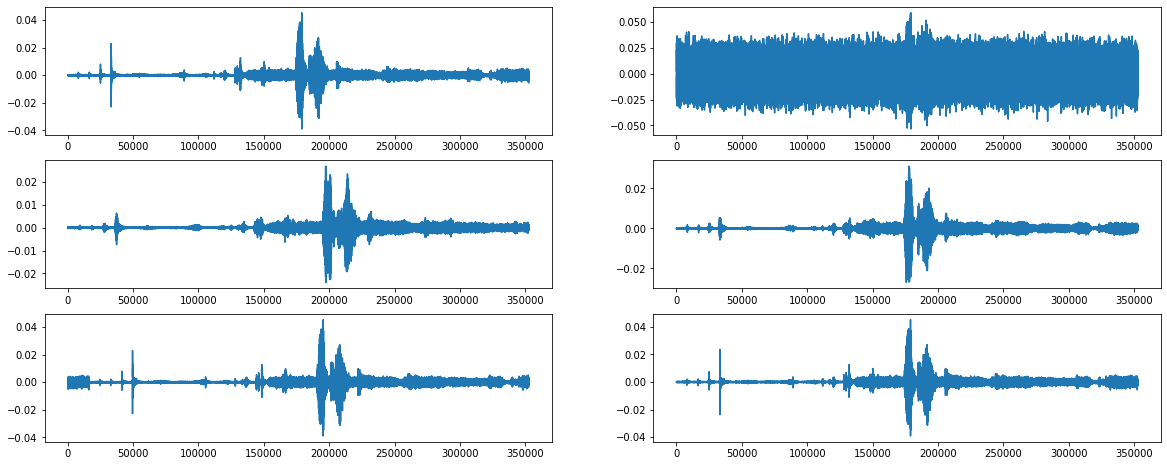

In [67]:
plot_waveform_transform(all_transforms)

In [68]:
all_transforms[0] , all_transforms[-1]

(array([-6.1035156e-05, -1.9836426e-04, -1.0681152e-04, ...,
         8.8500977e-04,  9.6130371e-04,  1.0528564e-03], dtype=float32),
 array([-3.0281588e-05, -1.2018989e-04, -1.5145053e-04, ...,
         6.9947058e-04,  9.7891130e-04,  1.0279634e-03], dtype=float32))

In [69]:
def save_waveform(wav, save_name):
    # sf.write('augmented.wav', wav, 48000, 'PCM_24')
    scipy.io.wavfile.write(f'augmented_files/{save_name}',44100,wav)

In [70]:
for ind, w in enumerate(all_transforms):
    save_waveform( w ,  f'{ind}.wav'  )

## Using torch audio .. let's see

In [71]:
import torchaudio

In [72]:
all_transforms[0].shape

(352800,)

In [96]:
melspectogram_transform = torchaudio.transforms.MelSpectrogram(
  sample_rate=sr, n_mels=128, n_fft=2048, f_max=12000, hop_length=512)
melspectogram_db_transform = torchaudio.transforms.AmplitudeToDB(top_db=80)

In [97]:
from torch import Tensor
melspectogram = melspectogram_transform(Tensor( wav ))

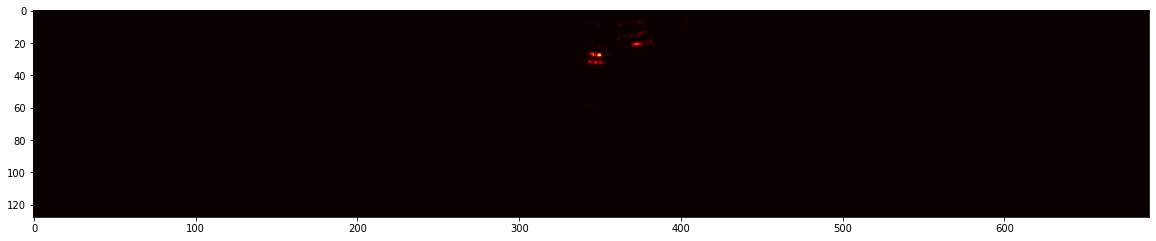

In [98]:
plt.figure(figsize=(20,6))
plt.imshow(melspectogram.squeeze(), cmap='hot')

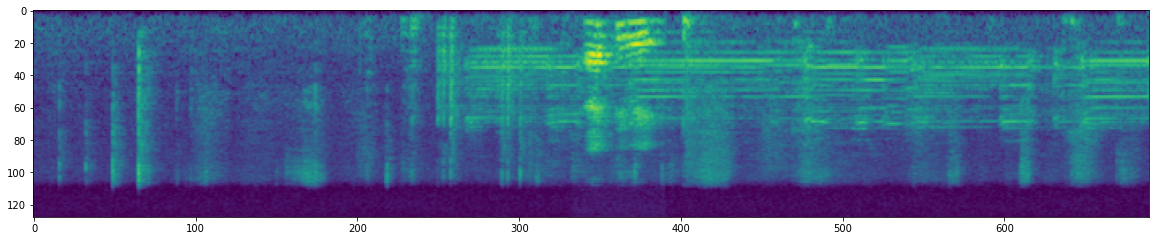

In [106]:
melspectogram_db=melspectogram_db_transform(melspectogram)
plt.figure(figsize=(20,6))
plt.imshow(melspectogram_db.squeeze().numpy())

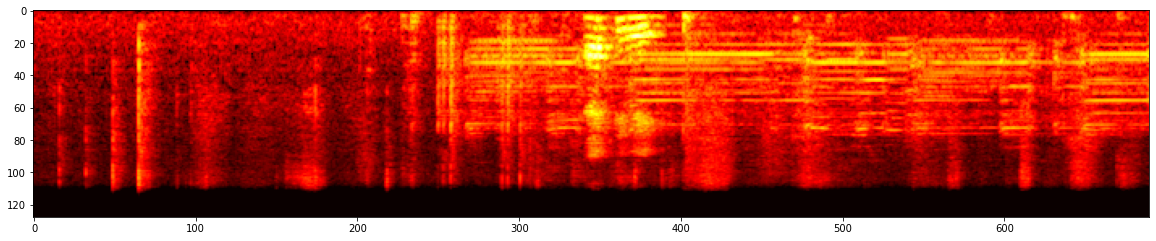

In [105]:
plt.figure(figsize=(20,6))
plt.imshow(get_melspectrogram_db( rand_sound_path ), cmap='hot')

In [104]:
melspectogram_db

tensor([[-48.5786, -52.1354, -59.6497,  ..., -59.6497, -36.7560, -30.2861],
        [-46.5425, -54.1431, -55.8488,  ..., -57.6208, -37.0354, -29.9574],
        [-43.4454, -49.3424, -47.5883,  ..., -49.7207, -36.9426, -29.7844],
        ...,
        [-56.2185, -56.4265, -57.0090,  ..., -58.4889, -58.6239, -57.1787],
        [-58.3686, -57.9841, -58.1997,  ..., -57.9111, -57.9156, -59.2032],
        [-57.7916, -57.9147, -58.3168,  ..., -55.6945, -58.6574, -59.6497]])

array([[-59.00894 , -65.040405, -69.50414 , ..., -71.24461 , -48.71225 ,
        -41.86876 ],
       [-52.198433, -55.077015, -54.088245, ..., -56.327805, -47.63791 ,
        -42.417274],
       [-48.907276, -50.90638 , -50.77977 , ..., -45.35616 , -44.419342,
        -47.549065],
       ...,
       [-74.476   , -74.476   , -74.476   , ..., -74.476   , -74.476   ,
        -74.476   ],
       [-74.476   , -74.476   , -74.476   , ..., -74.476   , -74.476   ,
        -74.476   ],
       [-74.476   , -74.476   , -74.476   , ..., -74.476   , -74.476   ,
        -74.476   ]], dtype=float32)

In [102]:
def get_melspectrogram_db(
    file_path,
    sr=44100,
    n_fft=2048,
    hop_length=512,
    n_mels=128,
    fmin=0,
    fmax=12000,
    top_db=80,
):
    wav, sr = librosa.load(file_path, sr=sr)
    spec = librosa.feature.melspectrogram(
        wav,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        fmin=fmin,
        fmax=fmax,
    )
    spec_db = librosa.power_to_db(spec, top_db=top_db)
    return spec_db